## Introduction

In this exploratory machine learning project, I investigate the classification of brain tumors using MRI-derived feature data. The goal is to build a predictive model capable of distinguishing between four tumor types (Pituitary Adenoma, Germinoma, Meningiomas and Glioma) based on high-dimensional numerical features extracted from medical imaging.

To achieve this, I use a Naive Bayes classifier, combined with feature selection techniques to reduce dimensionality, and explore prediction uncertainty through both calibrated probabilities and statistical analysis. The focus is not only on model performance, but also on how confident and reliable the predictions are, ehich is an essential aspect in real-world medical decision-making.

The data are taken from a kaggle dataset (https://www.kaggle.com/datasets/michaelchalamet/brain-cancer-data, and more details on the dataset therein) and consists of 700 samples, each described by 1500 numerical features extracted from MRI scans. The target variable is the tumor class, with labels ranging from 1 to 4. 

This project was implemented using Python, scikit-learn, and matplotlib, and includes both visual and statistical analysis of classification and uncertainty.

## Data loading and cleaning

Here I explore structure of the data and prepare them for the training.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split


df = pd.read_excel('BrainCancerData.xlsx')

print(df.head())
print(df.info())

# Drop unnecessary ID column
df.drop(columns=['No.'], inplace=True)

# Rename label column for convenience
df.rename(columns={'class label': 'label'}, inplace=True)

# Separate features and target
X = df.drop(columns=['label'])
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

   No.        v1        v2        v3        v4        v5        v6        v7  \
0    1  2.938354  3.138208  3.300422  3.221013  3.814756  4.494703  3.427234   
1    2  2.491011  1.510817  1.658108  2.302325  2.875599  1.575391  2.244480   
2    3  3.644503  2.845455  4.309304  4.166156  4.056208  3.683680  3.085278   
3    4  1.860832  3.873751  1.086140  1.725553  1.833238  3.357366  3.546659   
4    5  2.563717  1.412766  2.401923  3.063189  3.289470  2.703286  2.807458   

         v8        v9  ...     v1492     v1493     v1494     v1495     v1496  \
0  2.044687  2.745238  ...  0.243287  1.003977 -0.518222 -1.472913 -0.239216   
1  2.614274  3.151004  ... -0.981711 -1.225290 -0.125534 -0.705315  0.116246   
2  3.315754  3.487620  ...  0.073161 -0.610658  0.127932 -0.331715  0.793684   
3  3.761367  3.919646  ... -0.012919  0.512803 -0.523655 -0.463826  0.519912   
4  3.678409  2.666864  ... -0.979546  0.587593 -2.058093 -0.224098  0.490356   

      v1497     v1498     v1499     v1

## Feature distribution exploration

Before building the model, I explored several individual features to better understand the dataset. Since the dataset contains over 1500 unnamed variables (v1, v2, ..., v1500) and lacks detailed documentation, I examined their distributions across tumor classes.

As seen below, some features show overlapping distributions between classes, while others appear more discriminative. However, I also observed that several features follow similar shapes or occupy similar value ranges, which may indicate feature redundancy or statistical dependence.

These insights motivated the use of feature selection later on, to retain only the most informative variables and reduce noise.

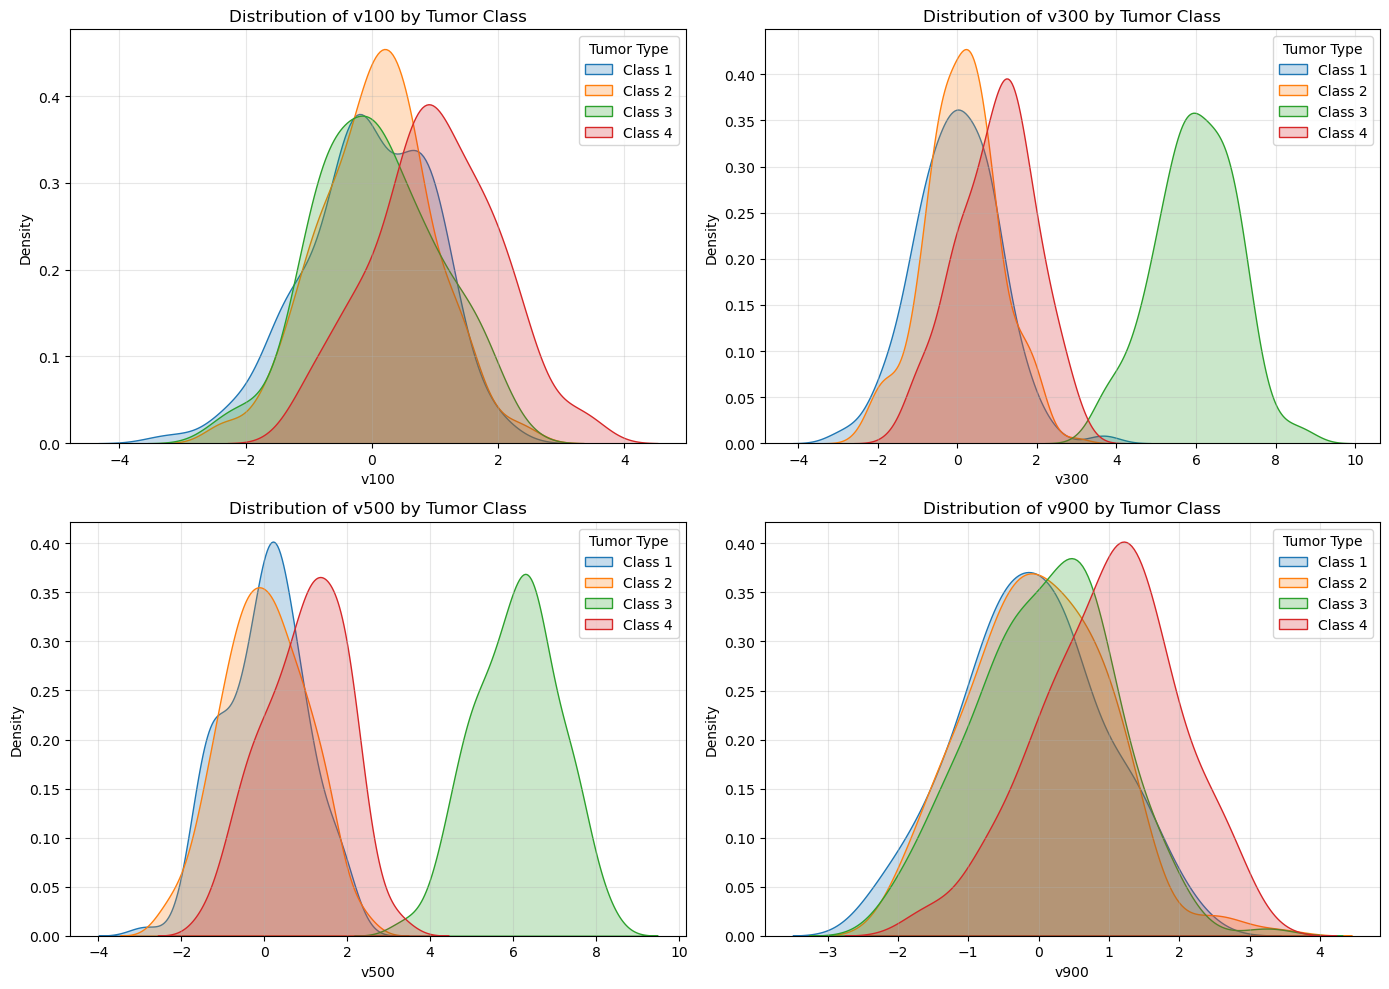

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick a few interesting features to visualize
features_to_plot = ['v100', 'v300', 'v500', 'v900']  # or random picks

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    for label in sorted(df['label'].unique()):
        sns.kdeplot(df[df['label'] == label][feature], label=f'Class {label}', fill=True)
    plt.title(f'Distribution of {feature} by Tumor Class')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend(title='Tumor Type')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Feature selection**.
While these plots helped reveal basic patterns, the absence of feature names or domain-specific descriptions made interpretation challenging. Still, the visual similarities across features suggested potential dependencies, which is important given that models like Naive Bayes assume conditional independence of features.

Based on this, I applied feature selection before training the classifier.

I applied univariate feature selection using SelectKBest with the ANOVA F-statistic scoring function (f_classif).
The idea is to evaluate each feature independently and assess how well it discriminates between the target classes.
For each feature, we compare the mean values across the different tumor classes. If the means are very different, that feature likely helps in classification. If the means are very similar, the feature might not carry much discriminative power. 
The F-score is computed for each feature $x_j$ as:
$$
F_j = \frac{\rm Variance \,\, between \,\, classes}{\rm Variance \,\, within \,\, classes} = \frac{\sum_{k=1}^K n_k (\bar x_{j,k}-\bar x_j)²}{\sum_{k=1}^K \sum_{i=1}^{n_k} (x_{ij}^{n_k}-x_{j,k})²}
$$
Where:
- $k$ = number of classes
- $n_k$ = number of samples in class $k$
- $\bar x_{j,k}$ = mean of feature $j$ for class $k$
- $\bar x_j$ = overall mean of feature $j$
- $x_{ij}^{n_k}$ = value of feature $j$ for sample $i$ in class $k$

A high F-score means the feature varies a lot between classes, and is probably useful for classification.
A low F-score means the feature values are similar across all classes, and it's likely less informative.

Note: I have chosen k=500 in SelectKBest as I tried k = 50, 100, 200, 500 and see how the model performs considering its accuracy.


In [3]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=500)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

Brief parenthesis:
**Dimensionality Reduction with PCA (Principal Component Analysis)**

In addition to feature selection, I also explored Principal Component Analysis (PCA) as a dimensionality reduction technique.

PCA transforms the original high-dimensional feature space into a smaller set of linearly uncorrelated components, called principal components. Each principal component captures as much variance from the original data as possible, with the first component capturing the most variance, the second one the second-most, and so on.

PCA computes a new set of axes (principal components) by:
- centering the data,
- computing the covariance matrix,
- finding the eigenvectors and eigenvalues of that matrix,
- projecting the data onto the top-k eigenvectors (those with the largest eigenvalues),

Mathematically, if $X$ is the data matrix, PCA solves:
$$
argmax_Ẉ \, Var (X|W)
$$
where $W$ is the matrix of eigenvectors corresponding to the top $k$ eigenvalues of the covariance matrix $X^{T}X$.

I applied PCA after feature selection using the following code:

from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_sel)
X_test_pca = pca.transform(X_test_sel)

This reduced the feature space from 500 selected features down to 50 principal components.

While PCA helped reduce dimensionality, I observed that the model (particularly Naive Bayes) became overconfident in its predictions after PCA was applied. Probabilities were often close to 1.0 with little uncertainty, even on difficult samples.

This may be due to the fact that PCA transforms the data into a new space where the Naive Bayes assumption of feature independence may no longer hold. As a result, the model may interpret the transformed features as more "separable" than they actually are.

For this reason, I chose to remove PCA and rely solely on feature selection, which preserved interpretability and yielded more reliable uncertainty estimates.

This experiment showed that dimensionality reduction is not always helpful unless it aligns well with the model’s assumptions. PCA can be very useful in other settings, but in this case, simpler was better.

## Model and training

For the classification task, I chose a Naive Bayes model, specifically the Gaussian Naive Bayes variant.
This algorithm is simple, interpretable, and naturally provides class probabilities, which makes it a great starting point for exploring both classification and prediction uncertainty.

Naive Bayes is based on Bayes’ theorem:
$$
P(y \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid y) \cdot P(y)}{P(\mathbf{x})}
$$
We do not need to compute $P(\mathbf{x})$ because we just care about the class with the highest posterior probability:
$$
\hat{y} = \arg\max_y \, P(y) \cdot P(\mathbf{x} \mid y)
$$

Naive Bayes assumes that all features are conditionally independent given the class:
$$
P(\mathbf{x} \mid y) = \prod_{j=1}^{n} P(x_j \mid y)
$$
This simplifies computation and allows the model to scale easily, but it’s a strong assumption — and can sometimes be unrealistic (as we discussed in the feature selection section).

In the Gaussian version of Naive Bayes (used for continuous features), we assume each feature value follows a normal distribution for each class:
$$
P(x_j \mid y) = \frac{1}{\sqrt{2\pi\sigma_{y,j}^2}} \exp\left( -\frac{(x_j - \mu_{y,j})^2}{2\sigma_{y,j}^2} \right)
$$
where:
- $\mu_{y,j}$ mean of feature $j$ for class $y$
- $\sigma_{y,j}^2$ : variance of feature $j$ for class $y$


In [4]:
from sklearn.naive_bayes import GaussianNB

#Model training
model = GaussianNB()
model.fit(X_train_sel, y_train)

GaussianNB()

## Model evaluation

The model was then evaluated on both the training and test sets to assess its performance:
- predict() was used to generate class predictions
- predict_proba() was used to obtain predicted class probabilities
- classification_report was used to measure precision, recall, and F1-score
- confusion_matrix was used to visualize which classes were correctly or incorrectly predicted

The classification report provides the following for each class:
- Precision: Of all samples predicted to belong to a class, how many were correct?
- Recall: Of all actual samples in a class, how many were correctly predicted?
- F1-score: The harmonic mean of precision and recall (it is high only when both precision and recall are high).

These metrics help assess the balance between false positives and false negatives for each tumor type.

The confusion matrix below provides a visual summary of prediction outcomes:
- diagonal elements show correct predictions,
- off-diagonal elements show misclassifications.
This is especially useful in multi-class problems like this one, where some tumor types may be confused with others.


🔍 Training Performance:

              precision    recall  f1-score   support

           1       0.71      0.85      0.77        91
           2       0.96      0.97      0.97       194
           3       1.00      1.00      1.00       131
           4       0.89      0.77      0.83       144

    accuracy                           0.91       560
   macro avg       0.89      0.90      0.89       560
weighted avg       0.91      0.91      0.91       560


🧪 Test Performance:

              precision    recall  f1-score   support

           1       0.63      0.77      0.70        31
           2       0.98      0.94      0.96        53
           3       1.00      1.00      1.00        24
           4       0.74      0.62      0.68        32

    accuracy                           0.84       140
   macro avg       0.84      0.84      0.83       140
weighted avg       0.85      0.84      0.84       140

Confusion Matrix:
[[24  0  0  7]
 [ 3 50  0  0]
 [ 0  0 24  0]
 [11  1  0 20]]


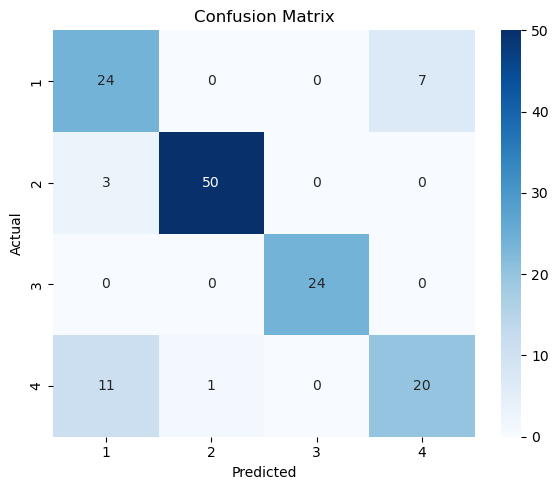

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = model.predict(X_test_sel)
y_proba = model.predict_proba(X_test_sel)

# Evaluate on training set
y_train_pred = model.predict(X_train_sel)
print('\n🔍 Training Performance:\n')
print(classification_report(y_train, y_train_pred))

# Evaluate on test set
print('\n🧪 Test Performance:\n')
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

**It can be useful to inspect the full class probability distribution for individual test samples.**

This following bar chart shows the model’s predicted probabilities for each of the four tumor types for one test sample. The true class label and the predicted class are shown in the plot title.

This helps answer questions like "how confident is the model in its prediction?" and "are other classes also considered likely, or is the prediction decisive?"

The height of each bar reflects the model’s belief in that class: values close to 1.0 indicate high confidence, while more distributed values suggest uncertainty or class confusion.

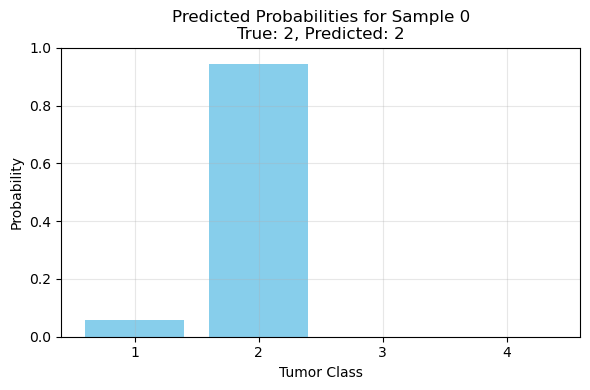

In [6]:
sample_index = 0 
probs = y_proba[sample_index]
true_label = y_test.iloc[sample_index]
pred_label = y_pred[sample_index]

plt.figure(figsize=(6, 4))
plt.bar([1, 2, 3, 4], probs, color='skyblue')
plt.xticks([1, 2, 3, 4])
plt.ylim(0, 1)
plt.title(f'Predicted Probabilities for Sample {sample_index}\nTrue: {true_label}, Predicted: {pred_label}')
plt.xlabel('Tumor Class')
plt.ylabel('Probability')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

To get a global view of how confident the model is across all test samples, I computed the maximum predicted probability for each sample. This value represents the model’s confidence in its prediction, the higher it is, the more certain the model is about the predicted class.

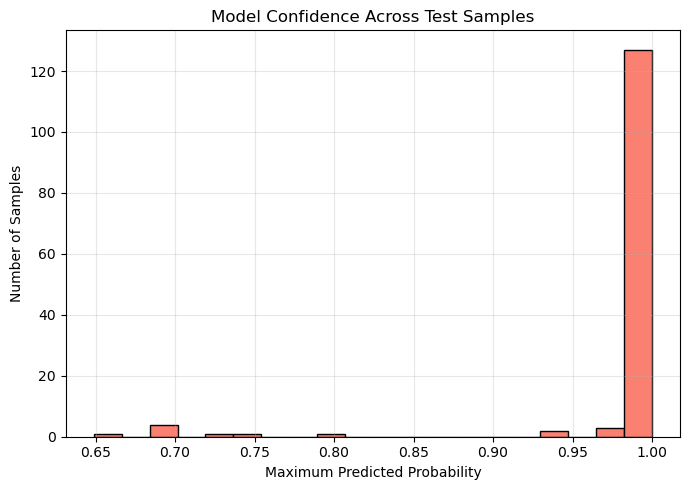

In [11]:
confidences = y_proba.max(axis=1)
uncertainties = 1 - confidences

plt.figure(figsize=(7, 5))
plt.hist(confidences, bins=20, color='salmon', edgecolor='black')
plt.title('Model Confidence Across Test Samples')
plt.xlabel('Maximum Predicted Probability')
plt.ylabel('Number of Samples')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

To assess how well the model generalizes to unseen data, I performed k-fold cross-validation on the training set using scikit-learn’s cross_val_score function.

I used 5-fold cross-validation, which means:
- the training data was split into 5 equal parts ("folds"),
- the model was trained on 4 folds and evaluated on the remaining 1,
- this process was repeated 5 times, rotating the validation fold each time.

The resulting accuracy scores were then averaged.

This gives a more robust estimate of the model’s performance, as it reduces the effect of a lucky or unlucky train-test split.

The cross-validation accuracy scores were relatively consistent, suggesting that the model performs stably across different training subsets.

In [8]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(GaussianNB(), X_train_sel, y_train, cv=5)
print("Cross-validation accuracy scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


Cross-validation accuracy scores: [0.86607143 0.875      0.86607143 0.84821429 0.88392857]
Mean CV accuracy: 0.8678571428571429


## Compare Confidence Distributions: Original vs Calibrated

Naive Bayes models tend to produce overconfident probability estimates, even when predictions are incorrect.
To address this, I applied probability calibration using CalibratedClassifierCV with Platt scaling (method='sigmoid').
Calibration adjusts the raw predicted probabilities to make them more statistically reliable, without changing the predicted class labels.

I used CalibratedClassifierCV with 5-fold cross-validation. The model is trained on each fold, and its probability outputs are passed through a sigmoid function to "flatten" or smooth overconfidence. This is known as Platt scaling, and it is suggestes to work especially well for models like Naive Bayes.

The code below compares the original vs calibrated predicted probabilities for a single test sample.

You’ll often see:
- original: one class has a probability near 1.0,
- calibrated: probabilities are less extreme, spreading some belief to other classes.

In practice, it has access to ground truth labels on the validation fold.

This reflects a more cautious and realistic model, crucial in fields like medicine, where blind confidence can be harmful.

I also generated a new classification report using the calibrated model.

In [9]:
from sklearn.calibration import CalibratedClassifierCV

# Wrap the base model with calibration
cal_model = CalibratedClassifierCV(GaussianNB(), cv=5, method='sigmoid')
cal_model.fit(X_train_sel, y_train)

# Predict calibrated probabilities
y_proba_cal = cal_model.predict_proba(X_test_sel)
y_pred_cal = cal_model.predict(X_test_sel)

# Compare original vs calibrated prediction for a sample
print(f"\n🔬 Comparison of Original vs Calibrated Probabilities (Sample {sample_index}):")
print("Original:", y_proba[sample_index])
print("Calibrated:", y_proba_cal[sample_index])

# Classification report with calibrated model
print("\n📊 Calibrated Model Performance:\n")
print(classification_report(y_test, y_pred_cal))


🔬 Comparison of Original vs Calibrated Probabilities (Sample 0):
Original: [5.64853045e-002 9.43514696e-001 0.00000000e+000 1.10901860e-226]
Calibrated: [0.11548526 0.79020612 0.01163388 0.08267474]

📊 Calibrated Model Performance:

              precision    recall  f1-score   support

           1       0.63      0.77      0.70        31
           2       0.98      0.94      0.96        53
           3       1.00      1.00      1.00        24
           4       0.74      0.62      0.68        32

    accuracy                           0.84       140
   macro avg       0.84      0.84      0.83       140
weighted avg       0.85      0.84      0.84       140



To further analyze the effect of calibration, I compared the distribution of predicted confidence between the original and calibrated models. 
For each test sample, I computed the model’s confidence as the maximum predicted class probability.
This histogram shows how these confidence scores are distributed before and after calibration.

Key observations:
- the original model produced a very large number of high-confidence predictions (many > 0.9),
- the calibrated model is significantly more cautious, avoiding overconfident predictions unless truly justified,
- the vertical dashed line at 0.9 marks the threshold for what we consider a "very confident" prediction.

In the printed output, you can also see how many predictions exceeded this threshold for each model.

This analysis highlights how calibration improves the trustworthiness of the predicted probabilities, making them better suited for real-world decision-making, especially in risk-sensitive domains like healthcare.


🔎 High-confidence predictions (> 0.9):
Original model:   132 out of 140 samples
Calibrated model: 0 out of 140 samples


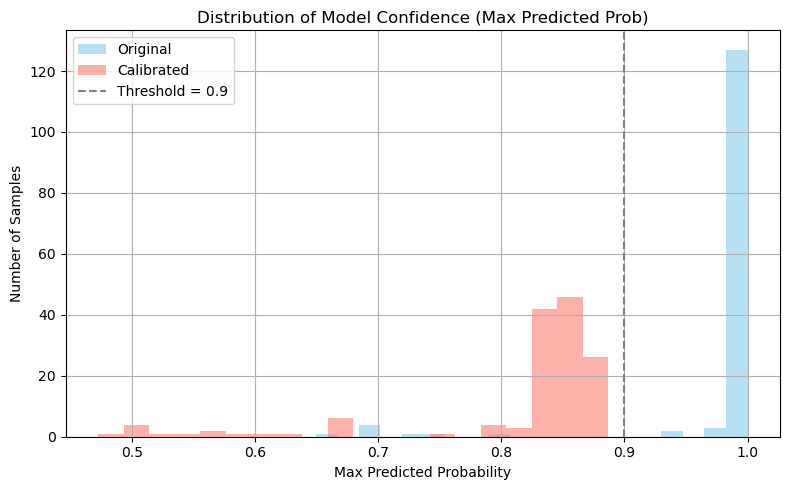

In [10]:
import numpy as np

# Get max predicted probabilities (confidence) per sample
orig_conf = y_proba.max(axis=1)
cal_conf = y_proba_cal.max(axis=1)

# Define threshold for "very high confidence"
threshold = 0.9

# Count how many predictions are above threshold
orig_high_conf = np.sum(orig_conf > threshold)
cal_high_conf = np.sum(cal_conf > threshold)

print("\n🔎 High-confidence predictions (> 0.9):")
print(f"Original model:   {orig_high_conf} out of {len(y_proba)} samples")
print(f"Calibrated model: {cal_high_conf} out of {len(y_proba)} samples")

# Plot histogram to visualize
plt.figure(figsize=(8, 5))
plt.hist(orig_conf, bins=20, alpha=0.6, label='Original', color='skyblue')
plt.hist(cal_conf, bins=20, alpha=0.6, label='Calibrated', color='salmon')
plt.axvline(threshold, color='gray', linestyle='--', label='Threshold = 0.9')
plt.title("Distribution of Model Confidence (Max Predicted Prob)")
plt.xlabel("Max Predicted Probability")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The original Naive Bayes model made 94%+ confident predictions on nearly every test sample — even when it was incorrect. After applying probability calibration (Platt scaling), the model became significantly more cautious, with no predictions exceeding 90% confidence. This shows that the uncalibrated model was overconfident, and calibration produced more realistic, reliable probability estimates.

This calibration doesn't affect accuracy or classification performance, but it dramatically improves the interpretability and trustworthiness of predicted probabilities.